# Pengenalan

Latar belakang memilih kasus ***Clean vs Messy Room*** untuk membuat dan melatih model agar dapat memprediksi gambar foto ruangan termasuk bersih atau berantakan.

# Import Library

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Download Dataset

In [3]:
!wget --no-check-certificate \
  https://github.com/kardiwan7/CNN-Clean-vs-Messy-Room/raw/main/Dataset/messy-vs-clean-room.zip \
  -O /tmp/messy_vs_clean_room.zip

--2023-01-01 04:29:36--  https://github.com/kardiwan7/CNN-Clean-vs-Messy-Room/raw/main/Dataset/messy-vs-clean-room.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kardiwan7/CNN-Clean-vs-Messy-Room/main/Dataset/messy-vs-clean-room.zip [following]
--2023-01-01 04:29:36--  https://raw.githubusercontent.com/kardiwan7/CNN-Clean-vs-Messy-Room/main/Dataset/messy-vs-clean-room.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70392746 (67M) [application/zip]
Saving to: ‘/tmp/messy_vs_clean_room.zip’

/tmp/messy_vs_clean 100%[===================>]  67.13M   168MB/s    in 0.4s    

2023-01-01 04:29:

### Extract Dataset

In [4]:
# ekstraksi pada file zip
import zipfile,os
local_zip = '/tmp/messy_vs_clean_room.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

### Check Directory

In [5]:
# check images/train directory
os.listdir('/tmp/images/train')

['messy', 'clean']

In [6]:
# check images/val directory
os.listdir('/tmp/images/val')

['messy', 'clean']

### Image Augmentation

*   Mengimplementasikan augmentasi gambar.
*   Menggunakan image data generator.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
                    rescale=1./255)

### Prepare the Data

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena ini merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, 
        # karena ini merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


### Create Model

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Compile the Model

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

### Callback
*   penggunaan Callback

In [13]:
# penggunaan Callback, accuracy threshold 97%
accuracy_threshold = 97e-2
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= accuracy_threshold:
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
            self.model.stop_training = True

### Training Model

In [14]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=25,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks = [my_callbacks()])

Epoch 1/25
25/25 - 13s - loss: 0.8387 - accuracy: 0.4100 - val_loss: 0.6939 - val_accuracy: 0.5000 - 13s/epoch - 529ms/step
Epoch 2/25
25/25 - 12s - loss: 0.6946 - accuracy: 0.4700 - val_loss: 0.6920 - val_accuracy: 0.5000 - 12s/epoch - 466ms/step
Epoch 3/25
25/25 - 12s - loss: 0.6926 - accuracy: 0.5600 - val_loss: 0.6846 - val_accuracy: 0.5500 - 12s/epoch - 463ms/step
Epoch 4/25
25/25 - 11s - loss: 0.6877 - accuracy: 0.5600 - val_loss: 0.7006 - val_accuracy: 0.5000 - 11s/epoch - 457ms/step
Epoch 5/25
25/25 - 11s - loss: 0.7041 - accuracy: 0.5200 - val_loss: 0.6899 - val_accuracy: 0.5000 - 11s/epoch - 458ms/step
Epoch 6/25
25/25 - 12s - loss: 0.6845 - accuracy: 0.5500 - val_loss: 0.6704 - val_accuracy: 0.5000 - 12s/epoch - 483ms/step
Epoch 7/25
25/25 - 12s - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6555 - val_accuracy: 0.5000 - 12s/epoch - 489ms/step
Epoch 8/25
25/25 - 12s - loss: 0.6961 - accuracy: 0.5000 - val_loss: 0.6984 - val_accuracy: 0.5000 - 12s/epoch - 494ms/step
Epoch 9/

In [15]:
print('Akurasi model = ', history.history['accuracy'][-1])

Akurasi model =  0.7799999713897705


In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

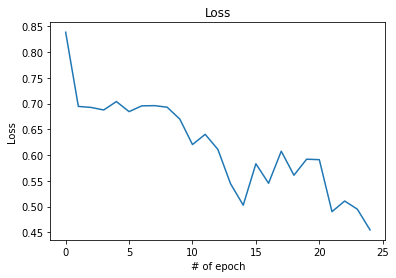

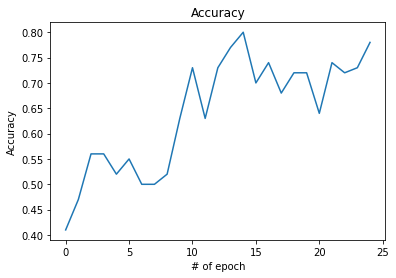

In [23]:
plt.plot(history.history['loss'])
plt.xlabel("# of epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

plt.plot(history.history['accuracy'])
plt.xlabel("# of epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()

### Predict an Image

In [27]:
print(train_generator.class_indices) 

{'clean': 0, 'messy': 1}


Saving 5.png to 5 (2).png
1/1 [==============================] - 0s 112ms/step
5.png
clean


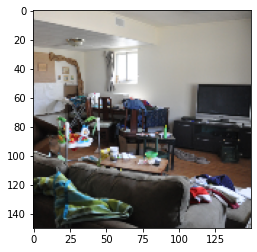

In [26]:
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)  
  print(fn)
  if classes==1:   
   print('messy')
  else:
   print('clean')